In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Analysis Report On Cardiovascular Disease Dataset

## Introduction

This report will be presenting an analysis on the dataset from [Kaggle](https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset) on Cardiovascular diseases. The dataset contains various features    
that are related to the target variable, cardiovascular disease, and aims predict the absence or presence of a cardiovascular disease in a person.  
In this report an analysis will be made around the features and later on a prediction using a machine learning model will be used to predict whether  
a person has or doesn't have a cardiovascular disease.

## Dataset overview
- Dataset Name: Cardiovascular Disease dataset
- Number of Instances: 70000
- Number of features: 12
- Target Variable: Presence or absence of cardiovascular disease

## Data pre-processing

In [16]:
cardio_data = pd.read_csv('../Data/cardio_train.csv', sep=';') # Load the data
cardio_data.dropna(inplace=True) # Drop missing values
cardio_data.drop_duplicates(inplace=True) # Drop duplicates
cardio_data['age'] = cardio_data['age'] // 365 # Turn the age from days into years
cardio_data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,61,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


In [17]:
bmi = cardio_data['weight'] / ((cardio_data['height'] / 100) ** 2)
bmi = pd.DataFrame({'bmi': bmi})

cardio_data = pd.concat([cardio_data, bmi], axis=1)
threshold = 3

z_scores_bmi = stats.zscore(cardio_data['bmi'])
outliers_bmi = cardio_data[abs(z_scores_bmi) > threshold]
cardio_data = cardio_data.drop(outliers_bmi.index)

z_scores_ap_lo = stats.zscore(cardio_data['ap_lo'])
outliers_ap_lo = cardio_data[abs(z_scores_ap_lo) > threshold]
cardio_data = cardio_data.drop(outliers_ap_lo.index)

z_scores_ap_hi = stats.zscore(cardio_data['ap_hi'])
outliers_ap_hi = cardio_data[abs(z_scores_ap_hi) > threshold]
cleaned_data = cardio_data.drop(outliers_ap_hi.index)

cleaned_data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,57,1,165,80.0,150,80,1,1,0,0,1,1,29.384757
69995,99993,52,2,168,76.0,120,80,1,1,1,0,1,0,26.927438
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1,31.353579
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1,27.099251


In [18]:
copy_one_df = cleaned_data.copy()
copy_two_df = cleaned_data.copy()

In [19]:
blood_pressure_ranges_systolic = pd.cut(cleaned_data['ap_hi'], bins=[0, 120, 130, 140, 180, 250], labels=[1, 2, 3, 4, 5])
blood_pressure_ranges_systolic = pd.DataFrame({'ap_hi_label': blood_pressure_ranges_systolic})

blood_pressure_ranges_diastolic = pd.cut(cleaned_data['ap_lo'], bins=[0, 80, 85, 90, 120, 180], labels=[1, 2, 3, 4, 5])
blood_pressure_ranges_diastolic = pd.DataFrame({'ap_lo_label': blood_pressure_ranges_diastolic})

bmi_categorical = pd.cut(bmi['bmi'], bins=[18.5, 25, 30, 35, 40, 100], labels=[1, 2, 3, 4, 5])
bmi_categorical = pd.DataFrame({'bmi_categorical': bmi_categorical})

copy_one_df = pd.concat([cleaned_data, blood_pressure_ranges_systolic, blood_pressure_ranges_diastolic, bmi_categorical], axis=1)
copy_one_df = pd.get_dummies(copy_one_df, columns=['ap_hi_label', 'gender','ap_lo_label', 'bmi_categorical'], dtype=int)
copy_one_df.drop(columns=['height', 'weight', 'ap_hi', 'ap_lo', 'bmi'], inplace=True)
copy_one_df.dropna(inplace=True)

copy_one_df

,id,age,cholesterol,gluc,smoke,alco,active,cardio,ap_hi_label_1,ap_hi_label_2,...,ap_lo_label_1,ap_lo_label_2,ap_lo_label_3,ap_lo_label_4,ap_lo_label_5,bmi_categorical_1,bmi_categorical_2,bmi_categorical_3,bmi_categorical_4,bmi_categorical_5
0,0.0,50.0,1.0,1.0,0.0,0.0,1.0,0.0,1,0,...,1,0,0,0,0,1,0,0,0,0
1,1.0,55.0,3.0,1.0,0.0,0.0,1.0,1.0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,2.0,51.0,3.0,1.0,0.0,0.0,0.0,1.0,0,1,...,1,0,0,0,0,1,0,0,0,0
3,3.0,48.0,1.0,1.0,0.0,0.0,1.0,1.0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,4.0,47.0,1.0,1.0,0.0,0.0,0.0,0.0,1,0,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992.0,57.0,1.0,1.0,0.0,0.0,1.0,1.0,0,0,...,1,0,0,0,0,0,1,0,0,0
69995,99993.0,52.0,1.0,1.0,1.0,0.0,1.0,0.0,1,0,...,1,0,0,0,0,0,1,0,0,0
69997,99996.0,52.0,3.0,1.0,0.0,1.0,0.0,1.0,0,0,...,0,0,1,0,0,0,0,1,0,0
69998,99998.0,61.0,1.0,2.0,0.0,0.0,0.0,1.0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [20]:
copy_two_df = pd.get_dummies(copy_two_df, columns=['gender'], dtype=int)
copy_two_df.drop(['height', 'weight'], axis=1, inplace=True)
copy_two_df

,id,age,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,gender_1,gender_2
0,0,50,110,80,1,1,0,0,1,0,21.967120,0,1
1,1,55,140,90,3,1,0,0,1,1,34.927679,1,0
2,2,51,130,70,3,1,0,0,0,1,23.507805,1,0
3,3,48,150,100,1,1,0,0,1,1,28.710479,0,1
4,4,47,100,60,1,1,0,0,0,0,23.011177,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,57,150,80,1,1,0,0,1,1,29.384757,1,0
69995,99993,52,120,80,1,1,1,0,1,0,26.927438,0,1
69997,99996,52,180,90,3,1,0,1,0,1,31.353579,0,1
69998,99998,61,135,80,1,2,0,0,0,1,27.099251,1,0


The dataset has gone through numerous preprocessing steps. In the first code block the dataset is loaded in and dropped rows where there is NA present in any cell. Any duplicates  
are also dropped. After that the column "age" had the cells turned from days into years to gain further clarification. In the second code block a BMI column is introduced  
and using that column and also both the blood pressure columns to perform a outlier detection and removal using statistics. The rows where the values give a z-score of higher  
than 3, which is the threshold, are removed from the dataset. In the last code block, categorical data is created and added for both the blood pressures and also the bmi, and the relevant  
columns used for the categorical data are dropped. The columns "height" and "weight" are also removed because of the BMI.

<Axes: >

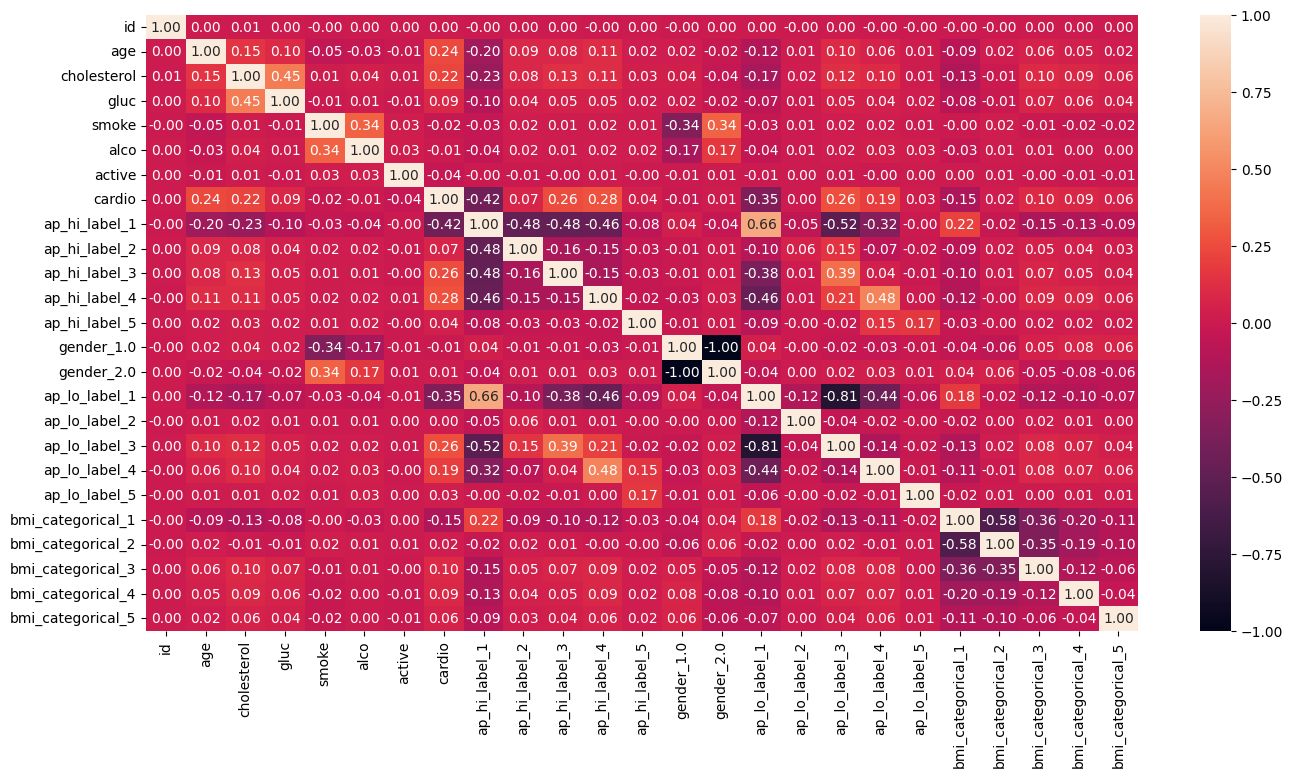

In [23]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(copy_one_df.corr(), annot=True, fmt=".2f")

In the correlation matrix above it was observed that the columns "active", "alco" and "smoke" had little to no correlation to the column "cardio". The column "active" had nearly no  
correlation at all to any other column. The columns alco and smoke only had a correlation to each other and also the gender, which did not play a significant role. Thus these  
three columns were dropped.

In [24]:
copy_one_df.drop(columns=['id', 'alco', 'smoke', 'active'], inplace=True)
copy_one_df

,age,cholesterol,gluc,cardio,ap_hi_label_1,ap_hi_label_2,ap_hi_label_3,ap_hi_label_4,ap_hi_label_5,gender_1.0,...,ap_lo_label_1,ap_lo_label_2,ap_lo_label_3,ap_lo_label_4,ap_lo_label_5,bmi_categorical_1,bmi_categorical_2,bmi_categorical_3,bmi_categorical_4,bmi_categorical_5
0,50.0,1.0,1.0,0.0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1,55.0,3.0,1.0,1.0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,1,0,0
2,51.0,3.0,1.0,1.0,0,1,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
3,48.0,1.0,1.0,1.0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
4,47.0,1.0,1.0,0.0,1,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,57.0,1.0,1.0,1.0,0,0,0,1,0,1,...,1,0,0,0,0,0,1,0,0,0
69995,52.0,1.0,1.0,0.0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
69997,52.0,3.0,1.0,1.0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
69998,61.0,1.0,2.0,1.0,0,0,1,0,0,1,...,1,0,0,0,0,0,1,0,0,0


<Axes: >

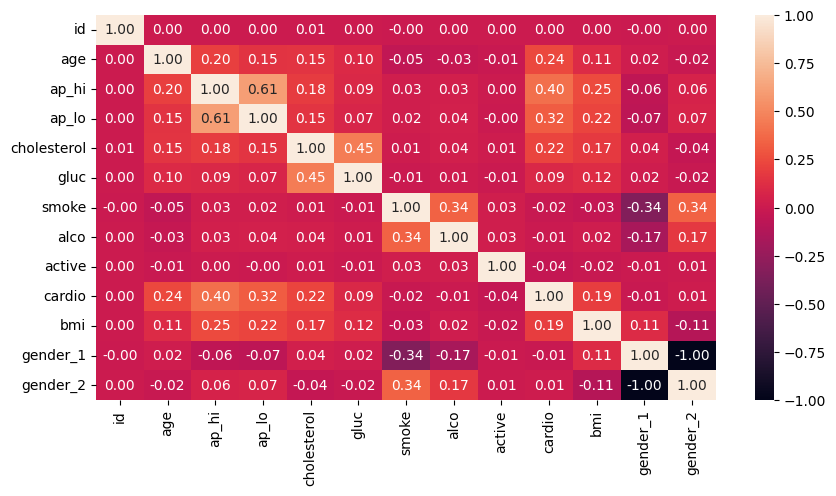

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(copy_two_df.corr(), annot=True, fmt=".2f")

In this correlation matrix we observed the same thing as the one that was observed before, thus it went through the same process.

In [26]:
copy_two_df.drop(columns=['id', 'alco', 'smoke', 'active'], inplace=True)
copy_two_df

,age,ap_hi,ap_lo,cholesterol,gluc,cardio,bmi,gender_1,gender_2
0,50,110,80,1,1,0,21.967120,0,1
1,55,140,90,3,1,1,34.927679,1,0
2,51,130,70,3,1,1,23.507805,1,0
3,48,150,100,1,1,1,28.710479,0,1
4,47,100,60,1,1,0,23.011177,1,0
...,...,...,...,...,...,...,...,...,...
69994,57,150,80,1,1,1,29.384757,1,0
69995,52,120,80,1,1,0,26.927438,0,1
69997,52,180,90,3,1,1,31.353579,0,1
69998,61,135,80,1,2,1,27.099251,1,0


lr pipeline test accuracy: 0.725
Best parameters:  {'clf__C': 0.1}
Confusion Matrix:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.81      0.75     34681
         1.0       0.77      0.64      0.70     33816

    accuracy                           0.72     68497
   macro avg       0.73      0.72      0.72     68497
weighted avg       0.73      0.72      0.72     68497



c:\Users\first\.virtualenvs\machine-learning-asajad-hussein-dtP5IciK\Lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
20 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\first\.virtualenvs\machine-learning-asajad-hussein-dtP5IciK\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\first\.virtualenvs\machine-learning-asajad-hussein-dtP5IciK\Lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^

knn pipeline test accuracy: 0.736
Best parameters:  {'clf__metric': 'euclidean', 'clf__n_neighbors': 47, 'clf__weights': 'uniform'}
Confusion Matrix:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.80      0.75     34681
         1.0       0.76      0.67      0.72     33816

    accuracy                           0.74     68497
   macro avg       0.74      0.74      0.73     68497
weighted avg       0.74      0.74      0.73     68497

nb pipeline test accuracy: 0.711
Best parameters:  {}
Confusion Matrix:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.84      0.75     34681
         1.0       0.78      0.58      0.66     33816

    accuracy                           0.71     68497
   macro avg       0.73      0.71      0.71     68497
weighted avg       0.73      0.71      0.71     68497

svc pipeline test accuracy: 0.729
Best parameters:  {'clf__C': 1, 'clf__kernel

c:\Users\first\.virtualenvs\machine-learning-asajad-hussein-dtP5IciK\Lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
20 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\first\.virtualenvs\machine-learning-asajad-hussein-dtP5IciK\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\first\.virtualenvs\machine-learning-asajad-hussein-dtP5IciK\Lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^

knn pipeline test accuracy: 0.739
Best parameters:  {'clf__metric': 'manhattan', 'clf__n_neighbors': 49, 'clf__weights': 'uniform'}
Confusion Matrix:
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.79      0.75     34681
           1       0.76      0.69      0.72     33816

    accuracy                           0.74     68497
   macro avg       0.74      0.74      0.74     68497
weighted avg       0.74      0.74      0.74     68497

nb pipeline test accuracy: 0.705
Best parameters:  {}
Confusion Matrix:
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.81      0.74     34681
           1       0.76      0.59      0.67     33816

    accuracy                           0.70     68497
   macro avg       0.71      0.70      0.70     68497
weighted avg       0.71      0.70      0.70     68497

svc pipeline test accuracy: 0.738
Best parameters:  {'clf__C': 10, 'clf__kerne

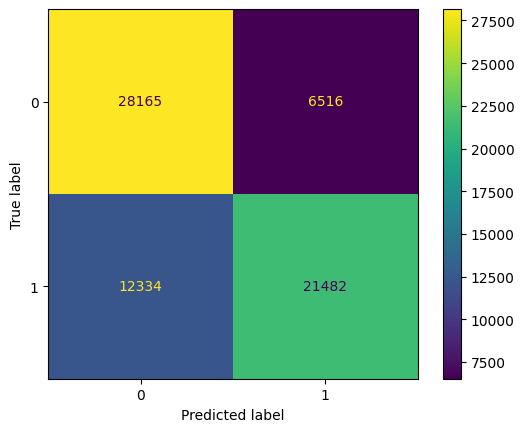

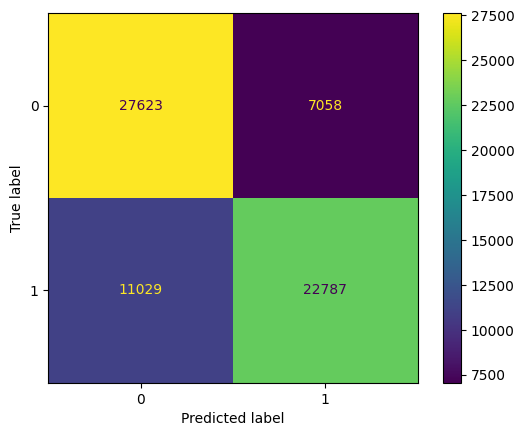

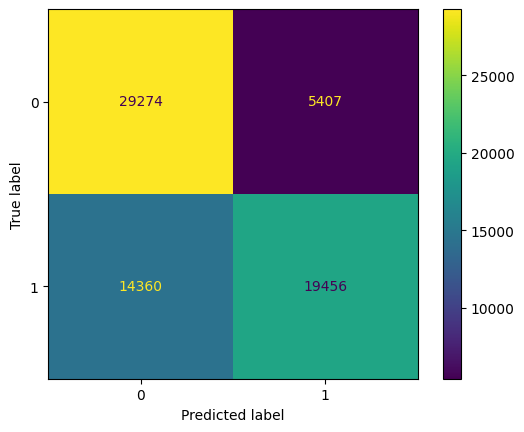

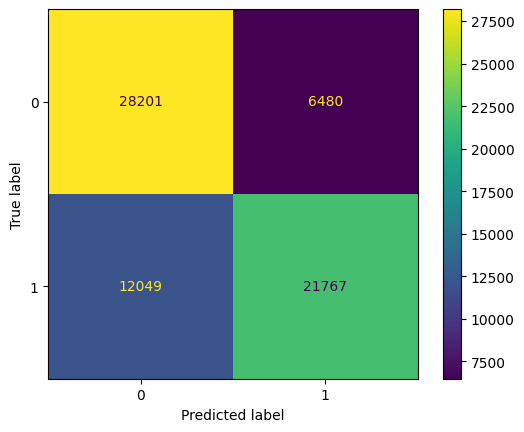

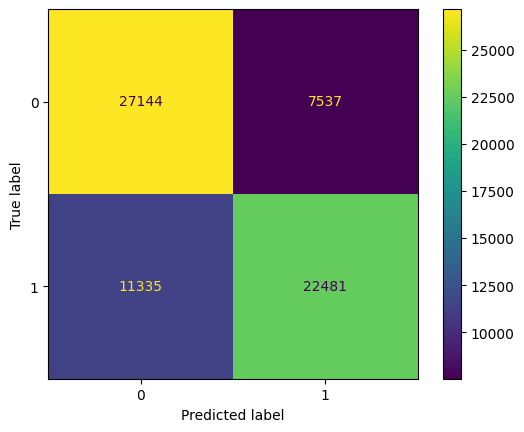

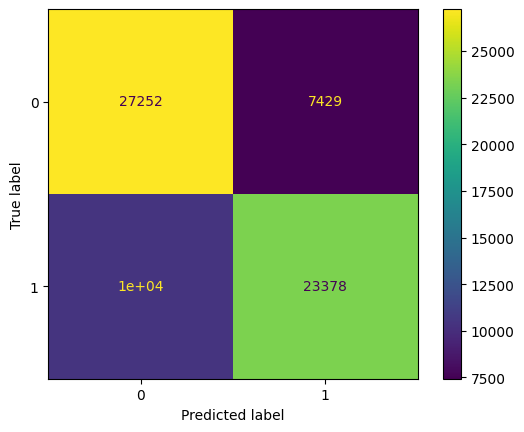

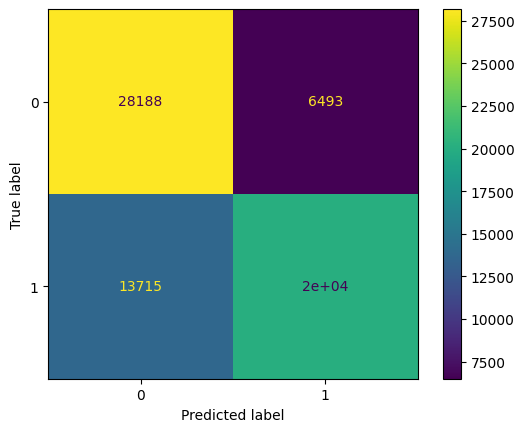

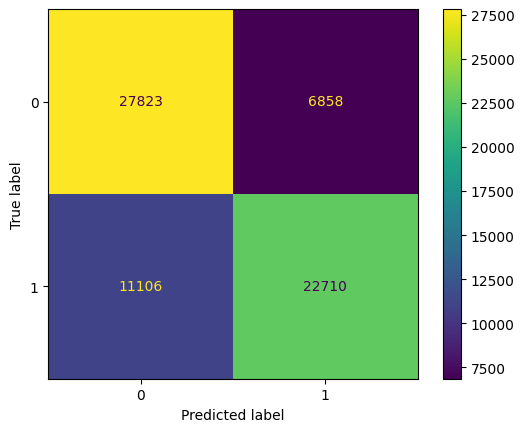

In [27]:
pipelines = {
    'lr': Pipeline([('scl', StandardScaler()), ('clf', LogisticRegression())]),
    'knn': Pipeline([('scl', StandardScaler()), ('clf', KNeighborsClassifier())]),
    'nb': Pipeline([('scl', StandardScaler()), ('clf', GaussianNB())]),
    'svc': Pipeline([('scl', StandardScaler()), ('clf', SVC())])
}

# Define the parameter grids
param_grids = {
    'lr': {'clf__C': [0.1, 1, 10]},
    'knn': {'clf__n_neighbors': list(range(50)), 'clf__weights': ['uniform', 'distance'], 'clf__metric': ['euclidean', 'manhattan']},
    'nb': {},
    'svc': {'clf__C': [0.1, 1, 10], 'clf__kernel': ['rbf']}
}

# Separate features and target
X_one = copy_one_df.drop('cardio', axis=1)
y_one = copy_one_df['cardio']

X_two = copy_two_df.drop('cardio', axis=1)
y_two = copy_two_df['cardio']

# Fit the GridSearchCV objects and print the best parameters
for name, pipeline in pipelines.items():
    grid = GridSearchCV(pipeline, param_grids[name], cv=5, n_jobs=-1)
    grid.fit(X_one, y_one)
    print(f'{name} pipeline test accuracy: {grid.score(X_one, y_one):.3f}')
    print('Best parameters: ', grid.best_params_)
    
    # Make predictions on the test data
    y_pred = grid.predict(X_one)

    # Print the confusion matrix
    print('Confusion Matrix:')
    cm = confusion_matrix(y_one, y_pred)
    ConfusionMatrixDisplay(cm).plot()

    # Print the classification report
    print('Classification Report:')
    print(classification_report(y_one, y_pred))

for name, pipeline in pipelines.items():
    grid = GridSearchCV(pipeline, param_grids[name], cv=5, n_jobs=-1)
    grid.fit(X_two, y_two)
    print(f'{name} pipeline test accuracy: {grid.score(X_two, y_two):.3f}')
    print('Best parameters: ', grid.best_params_)
    
    # Make predictions on the test data
    y_pred = grid.predict(X_two)

    # Print the confusion matrix
    print('Confusion Matrix:')
    cm = confusion_matrix(y_one, y_pred)
    ConfusionMatrixDisplay(cm).plot()

    # Print the classification report
    print('Classification Report:')
    print(classification_report(y_two, y_pred))

# Results

Four different models were tested in order to gain the model with highest accuracy and best parameters. The models tested were Logistic Regression, K nearest neighbours (KNN), Gaussian Naive Bayes, and Support Vector Classifier (SVC). All the models gained an accuracy in the range 0.700 to 0.750. Gaussian Naive Bayes had the lowest score at every test and thus was regarded the worst. Logistic regression consistently had a score of around 0.73 but was never the best. The tests were a battle between KNN and SVC, but in the end KNN had the best outcome with a score of 0.739. The best parameters were: "'clf__metric': 'manhattan', 'clf__n_neighbors': 49, 'clf__weights': 'uniform'".

Out of the two different datasets that were made, one was categorical and one was linear. The categorical gained a consistently higher score on almost all the tests, albeit not a tremendous gain over the other. However the best score came from the KNN on the linear dataset.

# Discussion

As observed in the confusion matrix, the amount of false positives is overwhelming among the incorrect predictions. This could be because of various of reasons.  
It might be because of insufficient useful parameters. The model might not have enough useful information to make a better prediction than the one that was made.  
Another reason might be because of overfitting. If the model is overfitted, the data might have performed well on the training data but not on the  
data that was unseen. Lastly, it could also be because of the way the data was preprocessed. Relevant features might have been removed that were useful, or the standardization technique  
used might have been the wrong choice for this case.

What could be tweaked to improve the results is using different models. There were other models that were not selected, such as random forest, decision trees and gradient descent  
that could potentially bring out a better result.

In [32]:
# Generate 100 random indices
X, y = copy_two_df.drop('cardio', axis=1), copy_two_df['cardio']

# Create a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=42)

# Combine the X_test and y_test DataFrames
test_samples = pd.concat([X_test, y_test], axis=1)

# Export these rows to a CSV file
test_samples.to_csv('test_samples.csv', index=False)

In [33]:
# Standardize the features
scaler = StandardScaler()

# Create and fit the KNN model
knn = KNeighborsClassifier(n_neighbors=49, weights='uniform', metric='manhattan')
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=49)

In [34]:
# Save the model to disk
joblib.dump(knn, 'knn_model.pkl')

['knn_model.pkl']